<a href="https://colab.research.google.com/github/shindeparth007/Gold-Price-Forecasting-ML/blob/main/Project_Gold_Price_Forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gold Price Forecasting ML Projet
# Author:Parth Shinde and Chidambar Kulkarni
# Guidance By:Prof. Pragnesh Shah
#Start Date:October 2025
#Description: Complete ML prediction for gold price forecasting using Indian market indicators


# Step 1: IMPORTS AND INITIAL SETUP


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


STEP 2: DATA LOADING AND CLEANING

In [53]:
def load_and_clean_data(csv_file='gold_price_indian_market_data.csv'):
    """
    Loading and cleaning the gold price dataset
    """
    print("STEP 2: DATA LOADING AND CLEANING")

    # Loading the data
    try:
        df = pd.read_csv(csv_file)
        print(f"Data loaded successfully from {csv_file}")
        print(f"Dataset shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found!")
        print("Please ensure the CSV file is in the same directory as this collab file.")
        return None

    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date').sort_index()

    # Displaying basic info to crosscheck
    print(f"   Date range: {df.index[0].date()} to {df.index[-1].date()}")
    print(f"   Gold price range: ₹{df['Target_Gold_Price_INR'].min():.2f} - ₹{df['Target_Gold_Price_INR'].max():.2f}")

    # Checking for the missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(f"Missing values found:")
        print(missing_values[missing_values > 0])
        df = df.dropna()
        print(f"After removing missing values: {df.shape[0]} samples")
    else:
        print("No missing values found")

    return df


In [54]:
df = load_and_clean_data('gold_price_indian_market_data.csv')

STEP 2: DATA LOADING AND CLEANING
Data loaded successfully from gold_price_indian_market_data.csv
Dataset shape: (1198, 22)
   Date range: 2020-12-02 to 2025-07-04
   Gold price range: ₹4192.46 - ₹8727.58
No missing values found


# STEP 3: CLASS IMBALANCE CHECK

In [55]:
def class_balance(df):
    """Class imbalance check with visuals and metrics"""
    print("\nSTEP 3: CLASS IMBALANCE ANALYSIS (WITH VISUALS)")
    print("-" * 55)

    # Distribution
    direction_counts = df['Price_Direction'].value_counts()
    direction_pct = df['Price_Direction'].value_counts(normalize=True) * 100

    print("Price Direction Distribution:")
    for direction in direction_counts.index:
        count = direction_counts[direction]
        pct = direction_pct[direction]
        print(f"{direction:>5}: {count:>4} samples ({pct:>5.1f}%)")

    # Balance metrics
    balance_ratio = direction_counts.min() / direction_counts.max()
    print(f"\nBalance Metrics:")
    print(f"Balance Ratio: {balance_ratio:.4f}")
    print(f"Imbalance Ratio: {direction_counts.max()/direction_counts.min():.2f}:1")

    # Assessment text
    if balance_ratio >= 0.8:
        status = "PERFECTLY BALANCED"; note = "No special handling required"
    elif balance_ratio >= 0.6:
        status = "WELL BALANCED"; note = "Proceed normally"
    elif balance_ratio >= 0.4:
        status = "MODERATELY IMBALANCED"; note = "Consider class weights / stratified split"
    elif balance_ratio >= 0.2:
        status = "SIGNIFICANTLY IMBALANCED"; note = "Use SMOTE or class weights"
    else:
        status = "SEVERELY IMBALANCED"; note = "Advanced resampling techniques needed"

    print(f"Assessment: {status}")
    print(f"Recommendation: {note}")

    return direction_counts, direction_pct, balance_ratio, status

In [56]:
# Class balance visualization
def visualize_class_balance(direction_counts, direction_pct, balance_ratio, status):
    """Visualize class balance using bar and pie charts."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar chart
    axes[0].bar(direction_counts.index, direction_counts.values,
                color=['green' if d == 'Up' else 'red' for d in direction_counts.index])
    axes[0].set_title('Class Counts (Up vs Down)')
    axes[0].set_ylabel('Count')

    # Pie chart
    axes[1].pie(direction_pct.values, labels=direction_pct.index,
                autopct='%1.1f%%', colors=['green', 'red'], startangle=90, pctdistance=0.8)
    axes[1].set_title('Class Percentage Distribution')

    # Annotation for balance ratio
    fig.suptitle(f"Class Balance Analysis • Balance Ratio: {balance_ratio:.4f} ({status})",
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()




STEP 3: CLASS IMBALANCE ANALYSIS (WITH VISUALS)
-------------------------------------------------------
Price Direction Distribution:
   Up:  608 samples ( 50.8%)
 Down:  590 samples ( 49.2%)

Balance Metrics:
Balance Ratio: 0.9704
Imbalance Ratio: 1.03:1
Assessment: PERFECTLY BALANCED
Recommendation: No special handling required


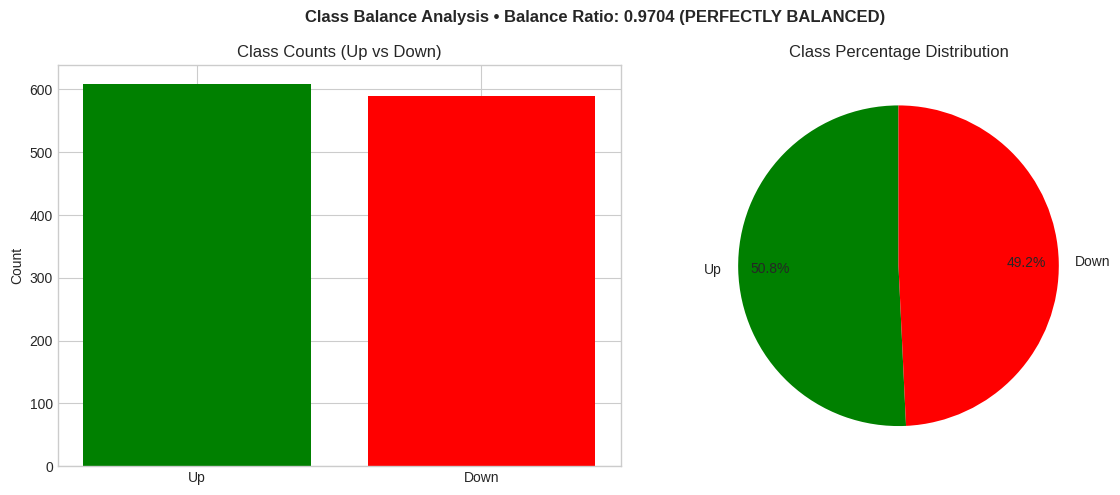

In [57]:
# Call the visualization function with the results from the previous step
direction_counts, direction_pct, balance_ratio, status = class_balance(df.reset_index().assign(Date=df.index).set_index('Date'))
visualize_class_balance(direction_counts, direction_pct, balance_ratio, status)

# STEP 4: EXPLORATORY DATA ANALYSIS

In [58]:
def eda_overview_and_quality(df):
    print("\nSTEP 4A: EDA = OVERVIEW & DATA QUALITY")
    print("-" * 45)

    print(f"Dimensions: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"Date Range: {df.index[0].date()} → {df.index[-1].date()}")

    # Target statistics
    tgt = df['Target_Gold_Price_INR']
    print("\nTarget (Gold Price INR) Summary:")
    print(f"Mean: ₹{tgt.mean():,.2f}")
    print(f"Median: ₹{tgt.median():,.2f}")
    print(f"Std Dev: ₹{tgt.std():,.2f}")
    print(f"Range: ₹{tgt.min():,.2f} - ₹{tgt.max():,.2f}")

    # Missing values
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("No missing values across columns")
    else:
        print("Missing values detected:")
        print(missing[missing > 0])

    # Time series plot
    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df['Target_Gold_Price_INR'], color='gold')
    plt.title('Gold Price (INR) Over Time')
    plt.ylabel('₹ per gram')
    plt.grid(True, alpha=0.3)
    plt.show()


In [59]:
def eda_features_correlations(df):
    print("\nSTEP 3B: EDA • FEATURE GROUPS & CORRELATIONS")
    print("-" * 50)

    # Feature groups
    price_features = [c for c in df.columns if 'Gold_' in c and c.endswith('INR')]
    market_features = ['NIFTY_50', 'India_VIX', 'INR_Index', 'USD_INR_Rate', 'Indian_Bond_10Y', 'Crude_Oil_Brent']

    print(f"Price Features: {len(price_features)} found")
    print(f"Market Indicators: {len([c for c in market_features if c in df.columns])} found")

    # Correlation heatmap
    corr_features = ['Target_Gold_Price_INR', 'NIFTY_50', 'India_VIX', 'USD_INR_Rate',
                     'Indian_Bond_10Y', 'INR_Index', 'Crude_Oil_Brent']
    corr = df[corr_features].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0, square=True,
                cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Matrix (Key Predictors vs Gold Price)')
    plt.show()

    # Key relationships
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].scatter(df['NIFTY_50'], df['Target_Gold_Price_INR'], alpha=0.5, color='green')
    axes[0].set_title('Gold Price vs NIFTY 50')
    z = np.polyfit(df['NIFTY_50'], df['Target_Gold_Price_INR'], 1)
    axes[0].plot(df['NIFTY_50'], np.poly1d(z)(df['NIFTY_50']), 'r--', alpha=0.8)

    axes[1].scatter(df['USD_INR_Rate'], df['Target_Gold_Price_INR'], alpha=0.5, color='purple')
    axes[1].set_title('Gold Price vs USD/INR')
    z2 = np.polyfit(df['USD_INR_Rate'], df['Target_Gold_Price_INR'], 1)
    axes[1].plot(df['USD_INR_Rate'], np.poly1d(z2)(df['USD_INR_Rate']), 'r--', alpha=0.8)

    for ax in axes:
        ax.set_xlabel(ax.get_title().split(' vs ')[1])
        ax.set_ylabel('Gold Price (₹/gram)')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



In [60]:
def eda_distribution_seasonality(df):
    print("\nSTEP 3C: EDA • DISTRIBUTION, OUTLIERS & SEASONALITY")
    print("-" * 55)

    tgt = df['Target_Gold_Price_INR']

    # Distribution
    plt.figure(figsize=(12, 4))
    plt.hist(tgt, bins=50, color='gold', edgecolor='black', alpha=0.8)
    plt.axvline(tgt.mean(), color='red', linestyle='--', label=f"Mean ₹{tgt.mean():.0f}")
    plt.title('Gold Price Distribution (INR)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Outliers (IQR)
    Q1, Q3 = tgt.quantile(0.25), tgt.quantile(0.75)
    IQR = Q3 - Q1
    low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = tgt[(tgt < low) | (tgt > high)]
    print(f"Outliers (IQR method): {len(outliers)} ({len(outliers)/len(tgt)*100:.1f}%)")

    # Seasonality (monthly)
    monthly = df.copy()
    monthly['Month'] = monthly.index.month
    month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    plt.figure(figsize=(14, 4))
    sns.boxplot(x='Month', y='Target_Gold_Price_INR', data=monthly, palette='viridis')
    plt.xticks(ticks=range(12), labels=month_names)
    plt.title('Monthly Seasonality: Gold Price Distribution')
    plt.ylabel('₹ per gram')
    plt.show()


STEP 4A: EDA = OVERVIEW & DATA QUALITY
---------------------------------------------
Dimensions: 1198 rows × 21 columns
Date Range: 2020-12-02 → 2025-07-04

Target (Gold Price INR) Summary:
Mean: ₹6,374.38
Median: ₹6,439.56
Std Dev: ₹1,221.14
Range: ₹4,192.46 - ₹8,727.58
No missing values across columns


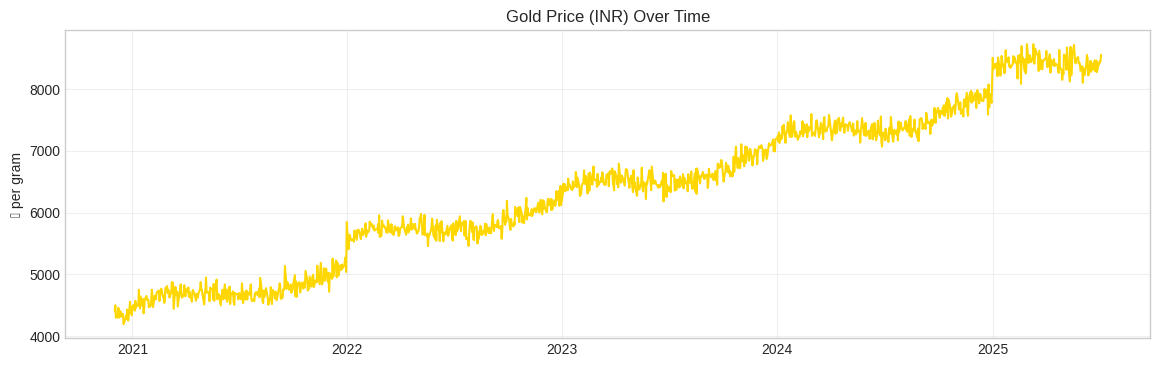

In [61]:
eda_overview_and_quality(df)


STEP 3B: EDA • FEATURE GROUPS & CORRELATIONS
--------------------------------------------------
Price Features: 8 found
Market Indicators: 6 found


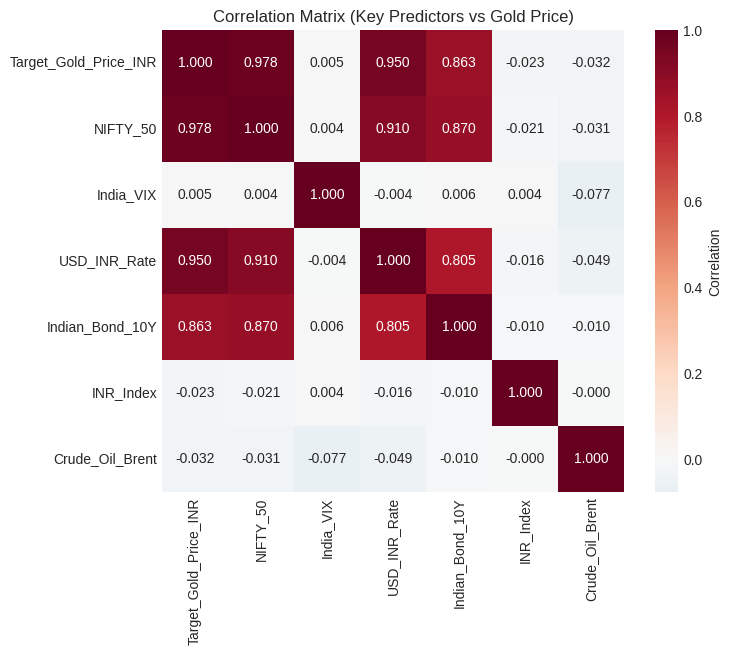

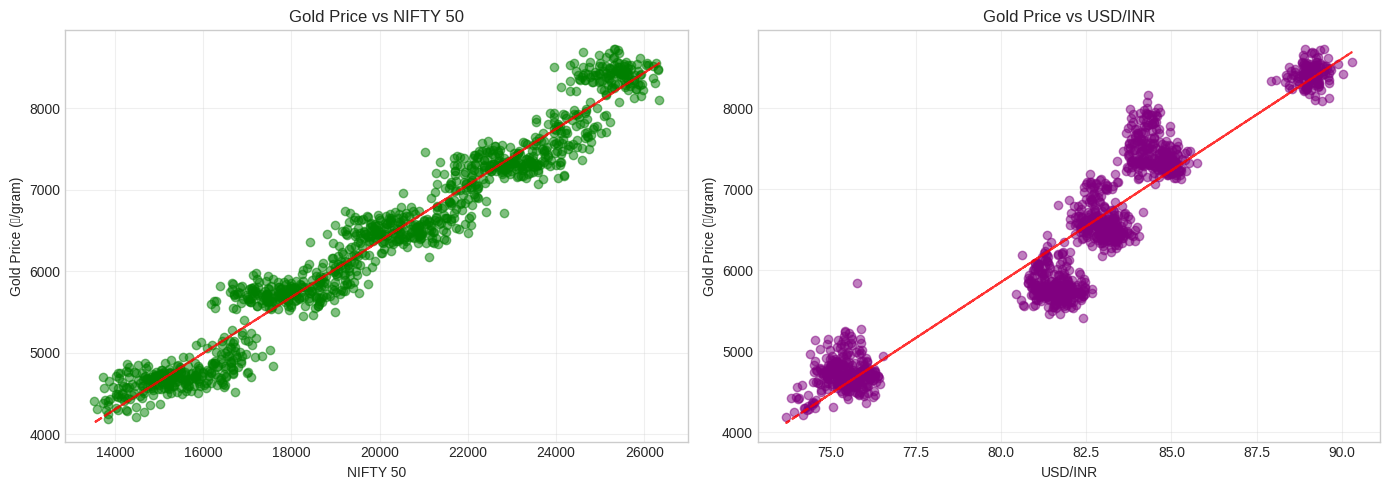

In [62]:
eda_features_correlations(df)


STEP 3C: EDA • DISTRIBUTION, OUTLIERS & SEASONALITY
-------------------------------------------------------


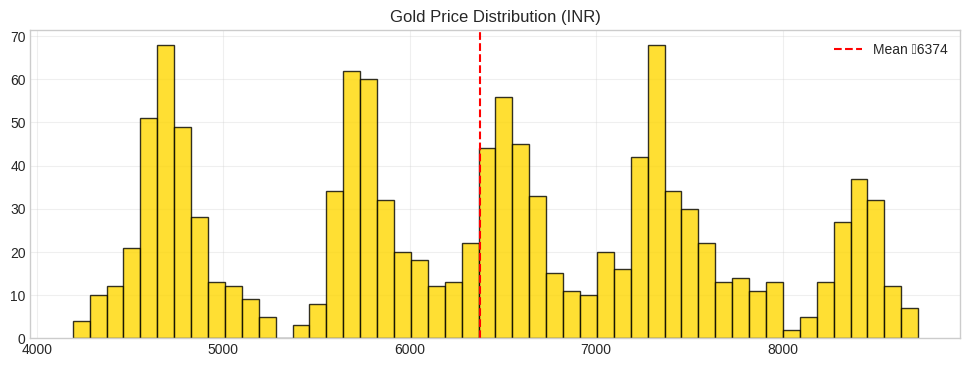

Outliers (IQR method): 0 (0.0%)


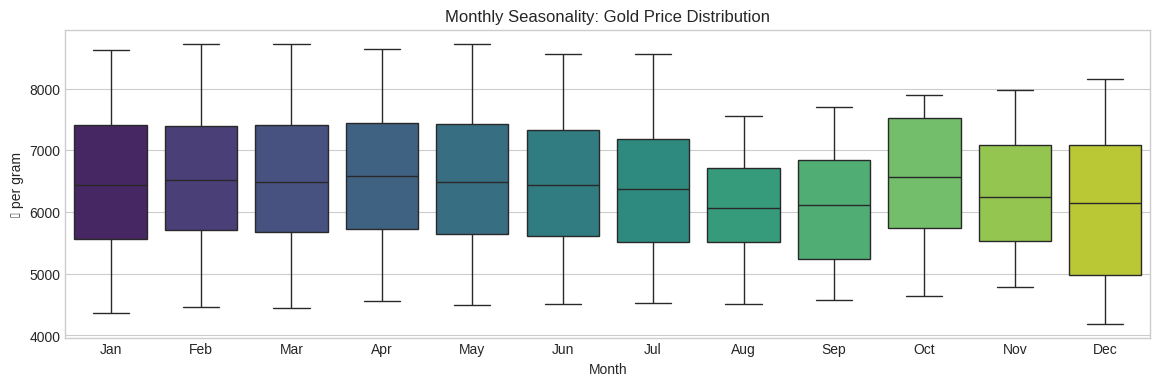

In [63]:
eda_distribution_seasonality(df)

# STEP 5: FEATURE ENGINEERING

In [64]:
def prepare_features(df):
    """
    Prepare feature matrix and target variable
    """
    print("\nSTEP 5: FEATURE ENGINEERING")
    print("-" * 28)

    # Defining feature columns (Indian market indicators)
    feature_columns = [
        'Gold_Open_INR', 'Gold_High_INR', 'Gold_Low_INR', 'Gold_Volume',
        'NIFTY_50', 'India_VIX', 'INR_Index', 'USD_INR_Rate',
        'Indian_Bond_10Y', 'Crude_Oil_Brent',
        'Gold_MA_5_INR', 'Gold_MA_20_INR', 'Gold_MA_50_INR',
        'Gold_Volatility', 'High_Low_Spread_INR', 'Open_Close_Change_INR'
    ]

    # Prepareing feature matrix and target
    X = df[feature_columns].copy()
    y = df['Target_Gold_Price_INR'].copy()

    print(f"Feature matrix Overview:")
    print(f"Features: {len(feature_columns)}")
    print(f"Samples: {len(X)}")

    # Displaying feature list
    print("\nSelected Features:")
    for i, feature in enumerate(feature_columns, 1):
        print(f"   {i:2d}. {feature}")

    return X, y, feature_columns

In [65]:
X, y, feature_columns = prepare_features(df)


STEP 5: FEATURE ENGINEERING
----------------------------
Feature matrix Overview:
Features: 16
Samples: 1198

Selected Features:
    1. Gold_Open_INR
    2. Gold_High_INR
    3. Gold_Low_INR
    4. Gold_Volume
    5. NIFTY_50
    6. India_VIX
    7. INR_Index
    8. USD_INR_Rate
    9. Indian_Bond_10Y
   10. Crude_Oil_Brent
   11. Gold_MA_5_INR
   12. Gold_MA_20_INR
   13. Gold_MA_50_INR
   14. Gold_Volatility
   15. High_Low_Spread_INR
   16. Open_Close_Change_INR


#Step 6: Model Training, Testing and Compare

In [66]:
def prepare_train_test_data(X, y, split_date='2024-01-01'):
    """
    Feature scaling and time-based train-test split
    """
    print("\nSTEP 5: PREPARING TRAIN AND TEST DATA")
    print("-" * 35)

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Time-based train-test split
    train_mask = X.index < split_date
    test_mask = X.index >= split_date

    X_train = X_scaled[train_mask]
    X_test = X_scaled[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]

    print(f"Train-Test Split:")
    print(f"Training: {len(X_train)} samples ({X_train.index[0].date()} to {X_train.index[-1].date()})")
    print(f"Testing: {len(X_test)} samples ({X_test.index[0].date()} to {X_test.index[-1].date()})")

    return X_train, X_test, y_train, y_test, scaler

In [67]:
X_train, X_test, y_train, y_test, scaler = prepare_train_test_data(X, y)


STEP 5: PREPARING TRAIN AND TEST DATA
-----------------------------------
Train-Test Split:
Training: 803 samples (2020-12-02 to 2023-12-29)
Testing: 395 samples (2024-01-01 to 2025-07-04)


In [68]:
def train_models(X_train, y_train):
    """
    Train multiple regression models
    """
    print("\nSTEP 6A: MODEL TRAINING")
    print("-" * 20)

    # Initialize models
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Support Vector Regressor": SVR(kernel='rbf')
    }

    trained_models = {}

    # Train models
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
        print(f"{name} trained.")

    return trained_models

In [69]:
trained_models = train_models(X_train, y_train)


STEP 6A: MODEL TRAINING
--------------------
Training Linear Regression...
Linear Regression trained.
Training Random Forest...
Random Forest trained.
Training Support Vector Regressor...
Support Vector Regressor trained.


In [70]:
def evaluate_and_compare_models(trained_models, X_test, y_test):
    """
    Evaluate and compare the performance of trained models
    """
    print("\nSTEP 6B: MODEL EVALUATION AND COMPARISON")
    print("-" * 40)

    results = {}

    for name, model in trained_models.items():
        print(f"\nEvaluating {name}...")

        # Make predictions
        y_pred_test = model.predict(X_test)

        # Calculate evaluation metrics
        r2 = r2_score(y_test, y_pred_test)
        mae = mean_absolute_error(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        results[name] = {
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse,
            "Predictions": y_pred_test
        }

        # Print metrics
        print(f"   Test R²: {r2:.4f}")
        print(f"   Test MAE: {mae:.2f}")
        print(f"   Test RMSE: {rmse:.2f}")


    print("\n📊 Model Comparison Summary:")
    print("-" * 30)
    for name, metrics in results.items():
        print(f"{name}:")
        print(f"  R²: {metrics['R2']:.4f}")
        print(f"  MAE: {metrics['MAE']:.2f}")
        print(f"  RMSE: {metrics['RMSE']:.2f}")

    return results

In [71]:
model_results = evaluate_and_compare_models(trained_models, X_test, y_test)


STEP 6B: MODEL EVALUATION AND COMPARISON
----------------------------------------

Evaluating Linear Regression...
   Test R²: 0.9298
   Test MAE: 102.30
   Test RMSE: 131.30

Evaluating Random Forest...
   Test R²: -2.4032
   Test MAE: 761.22
   Test RMSE: 914.49

Evaluating Support Vector Regressor...
   Test R²: -16.2083
   Test MAE: 1988.71
   Test RMSE: 2056.37

📊 Model Comparison Summary:
------------------------------
Linear Regression:
  R²: 0.9298
  MAE: 102.30
  RMSE: 131.30
Random Forest:
  R²: -2.4032
  MAE: 761.22
  RMSE: 914.49
Support Vector Regressor:
  R²: -16.2083
  MAE: 1988.71
  RMSE: 2056.37
